## As our data depends on time, we are going to analyze it as a Time Series.

### ONI simplified means that we only take into account the observations close to the equator in the ONI region  (0.5N-0.5S, 170W-120W)

### Import libraries

In [1]:
import pandas as pd
import itertools
import statsmodels.api as sm
from pylab import rcParams

#To plot
import matplotlib.pyplot as plt
import plotly.plotly as py
import cufflinks as cf
cf.go_offline()

### Import and check the data

In [132]:
data = pd.read_csv('../Data/Oni_simplified_region_label.csv')
data['date'] = pd.to_datetime(data['date'])

In [133]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,buoy_label
0,5796,1983,10,30,1983-10-30,-0.04,-124.54,-1.9,0.9,NaN,21.56,NaN,0
1,5797,1983,10,31,1983-10-31,-0.04,-124.54,-1.5,1.0,NaN,21.56,NaN,0
2,5798,1983,11,1,1983-11-01,-0.04,-124.54,-1.9,-0.1,NaN,21.64,NaN,0
3,5799,1983,11,2,1983-11-02,-0.04,-124.54,-0.9,-0.4,NaN,22.01,NaN,0
4,5800,1983,11,3,1983-11-03,-0.04,-124.54,-1.6,0.8,NaN,22.21,NaN,0


In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13080 entries, 0 to 13079
Data columns (total 13 columns):
obs           13080 non-null int64
year          13080 non-null int64
month         13080 non-null int64
day           13080 non-null int64
date          13080 non-null datetime64[ns]
latitude      13080 non-null float64
longitude     13080 non-null float64
zon.winds     12121 non-null float64
mer.winds     12121 non-null float64
humidity      6256 non-null float64
air temp.     11524 non-null float64
s.s.temp.     11864 non-null float64
buoy_label    13080 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(5)
memory usage: 1.3 MB


In [135]:
data.isnull().sum()

obs              0
year             0
month            0
day              0
date             0
latitude         0
longitude        0
zon.winds      959
mer.winds      959
humidity      6824
air temp.     1556
s.s.temp.     1216
buoy_label       0
dtype: int64

### Group the data by date and plot the data to see a first glimpse of it

In [136]:
g = data.groupby(by='date').mean()

In [137]:
g.shape

(5274, 12)

In [138]:
g.isnull().sum()

obs              0
year             0
month            0
day              0
latitude         0
longitude        0
zon.winds        2
mer.winds        2
humidity      2402
air temp.      287
s.s.temp.      165
buoy_label       0
dtype: int64

In [139]:
g.count()

obs           5274
year          5274
month         5274
day           5274
latitude      5274
longitude     5274
zon.winds     5272
mer.winds     5272
humidity      2872
air temp.     4987
s.s.temp.     5109
buoy_label    5274
dtype: int64

In [140]:
g['s.s.temp.'].rolling(window= 30).mean().iplot(kind='line', xTitle='Time',
           yTitle='Sea Temperature (ºC)', title='Sea temperature between 1980 and  1998')

### Clean and take the data for the analysis

#### We group our data by date, resampling it by months and check nan values.

In [142]:
y = data.groupby(by='date').mean()['s.s.temp.'].resample('MS').mean()
y.isnull().sum()

10

#### If, we then only take values from April 1984, we can avoid some nan values that are present in the data set. 

In [146]:
y[y.index > '1984-4-01'].isnull().sum()

2

#### We fill the 2 nan values of 1987-03-01 and 1987-04-01 with the intermediate values of 27.720290 and 28.092553.


In [147]:
y['1987-03-01'] = 27.720290
y['1987-04-01'] = 28.092553

#### If, we then only take values from April 1984, we skip all nan values related to sea surface temperature. 

In [150]:
y[(y.index > '1984-04-01')].isnull().sum()

0

In [151]:
y_rev = y[y.index > '1984-04-01']

#### Finally, we plot the cleaned and ready-to-analyze data

In [159]:
y_rev.iplot(kind='line', xTitle='Time',
           yTitle='Sea Temperature (ºC)', title='Sea surface temperature between 1984 and  1998')

### Decomposition Analysis

#### Decompose the time-series into three distinct components: trend, seasonality and noise

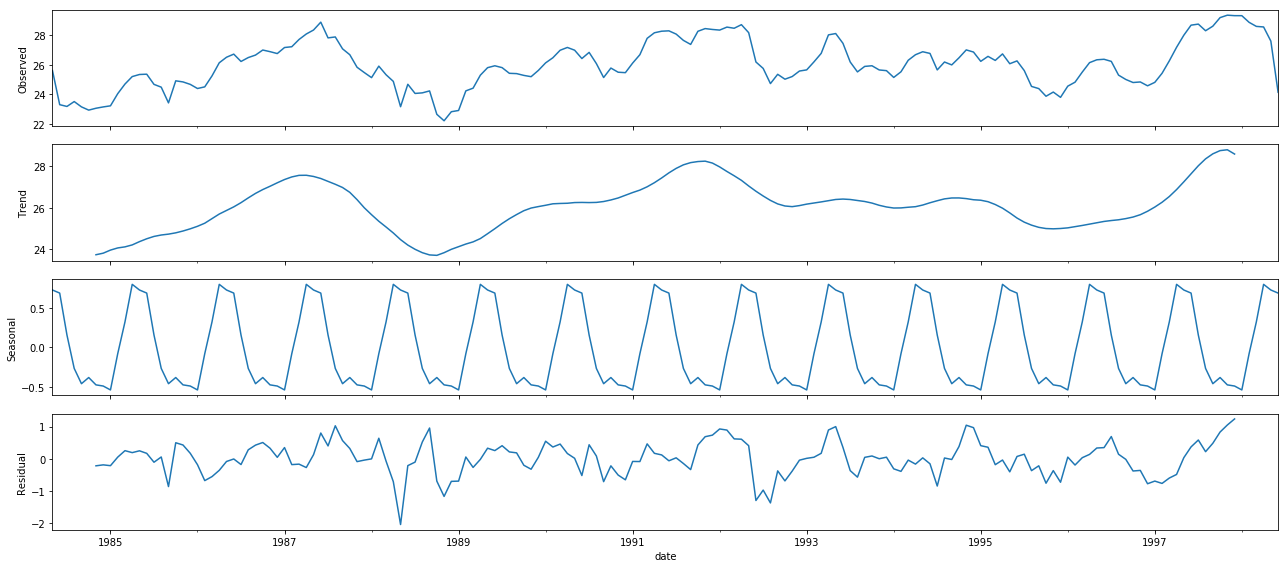

In [152]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_rev, model='additive')
fig = decomposition.plot()
plt.show()

## SARIMAX method

Autoregressive Integrated Moving Average, or ARIMA is a well established method for Time Series Analysis. However, it does not support seasonal data. As our data has seasonal components, we will use seasonal ARIMA or SARIMA instead. 

Moreover, ARIMA and SARIMA are only valid to stationary data. As the meteorological data we have tends to repeat over years (we will discard any climate change effect), we can considered it stationary. 

 Therefore, in order to analyze and forecast the meridional winds vs Time, we use the SARIMAX method.
The additional X means that the method is able to manage exogenous variables (variables that are not affected by others variables in the method). However, in this analysis we are not going to use them.

First, we need to find the most optimal SARIMAX parameters that fits with our data. To do so, we generate a combination of parameters that will be evaluated with our data. 

In [156]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [157]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [160]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_rev,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1584.0268187432512
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1306.5169371494558
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:669.6401319672681
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:582.5021624905319
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:671.8957342433921
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:608.2461383164418
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:622.253301379599
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:568.2960730504844
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1353.6604492310696
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1091.5147035528676
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:528.6468379426642
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:449.7150294802166
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:536.9647040133015


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:532.6816532377285
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:490.8234706780197
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:444.15636645048494
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:328.85178928999034
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:310.0094949065777
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:371.86201707549384
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:290.3523908664112
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:310.3764503405686
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:310.2709878006141
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:330.18226438113027


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:302.582215713437
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:325.10302492036544
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:305.92010462729604
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:369.5433574748781
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:289.9858692189595
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:308.9194797386567
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:305.906761437579
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:330.7374390469753
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:302.2238758302874
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:344.4105734378668
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:312.8619826814062


/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:379.5861708282164
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:292.47798794449517
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:312.2177075601687
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:314.2147766628987
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:328.5333220472883
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:294.4125870107939
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:328.058736951175
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:309.8329990751952
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:368.77795963090125
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:287.1100636782842
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:310.7341591316114
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:308.91789350229544
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:328.4810913881991
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:299.94328972803856
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:324.4098702840607
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:306.13913928441934
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:371.0511932108718
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:290.7973286976037
ARIMA(

The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

Thus, the parameters that are related to our most optimal fit are:

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:287.1100636782842

In [176]:
sarimax_model = sm.tsa.statespace.SARIMAX(y_rev,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = sarimax_model.fit()

print(results.summary())


                                 Statespace Model Results                                 
Dep. Variable:                          s.s.temp.   No. Observations:                  170
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -139.555
Date:                            Tue, 23 Apr 2019   AIC                            287.110
Time:                                    17:18:58   BIC                            298.989
Sample:                                05-01-1984   HQIC                           291.937
                                     - 06-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9172      0.043     21.482      0.000       0.834       1.001
ma.L1          0.1045      0.099   

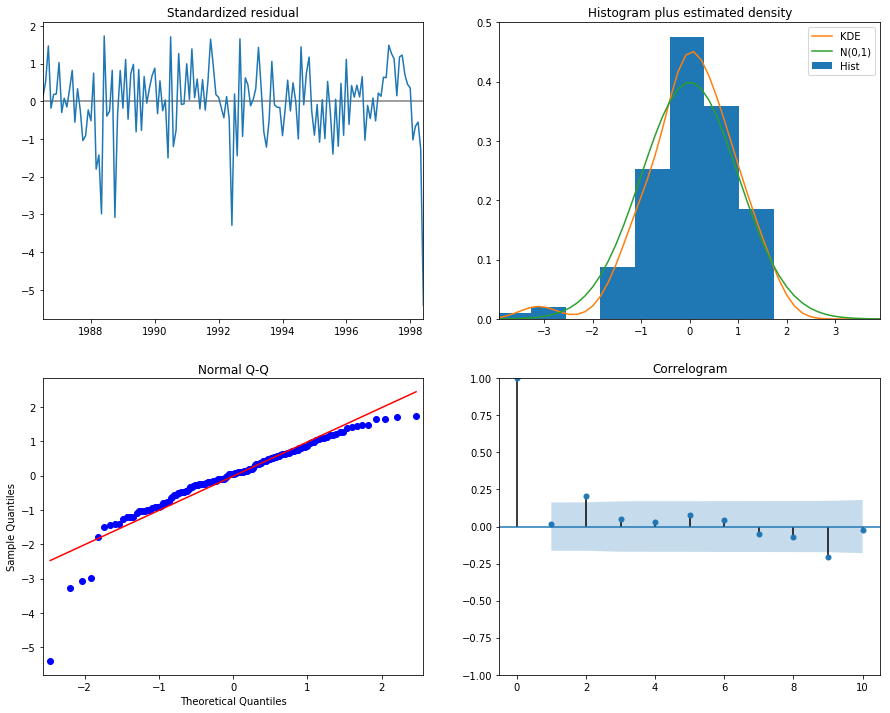

In [162]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In the top right plot, we see that the red KDE line follows the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1), except for the first section of the regression. Again, this is an indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

### Model prediction. 
#### We predict the meridional winds of the last years of data. 

In [166]:
pred = results.get_prediction(start=pd.to_datetime('1995-01-01'), dynamic=False)
pred_ci = pred.conf_int()

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

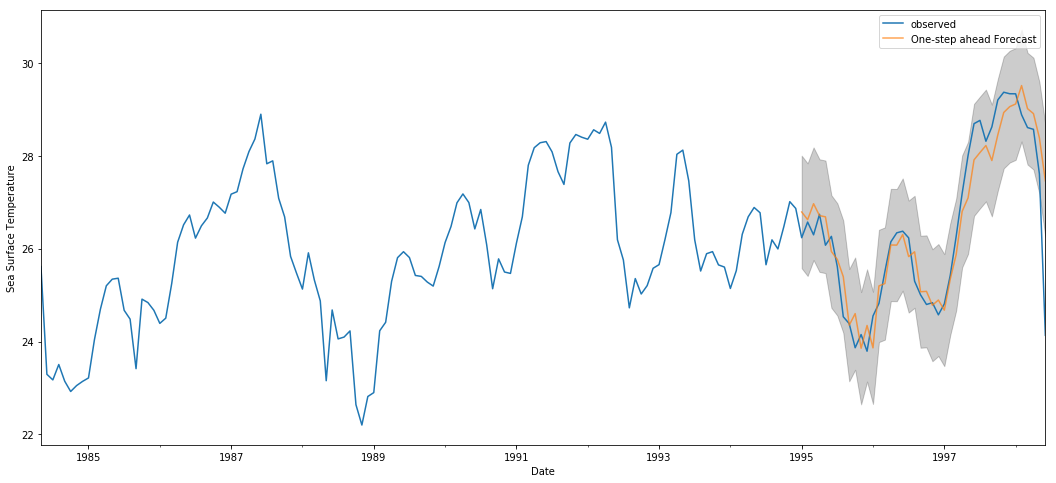

In [168]:
ax = y_rev['1980':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sea Surface Temperature')
plt.legend()


plt.show()

#### Model accuracy. 
We will use the MSE (Mean Squared Error) which summarize the average error of our forecasts. 

In [170]:
y_forecasted = pred.predicted_mean
y_truth = y_rev['1995-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.49


However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

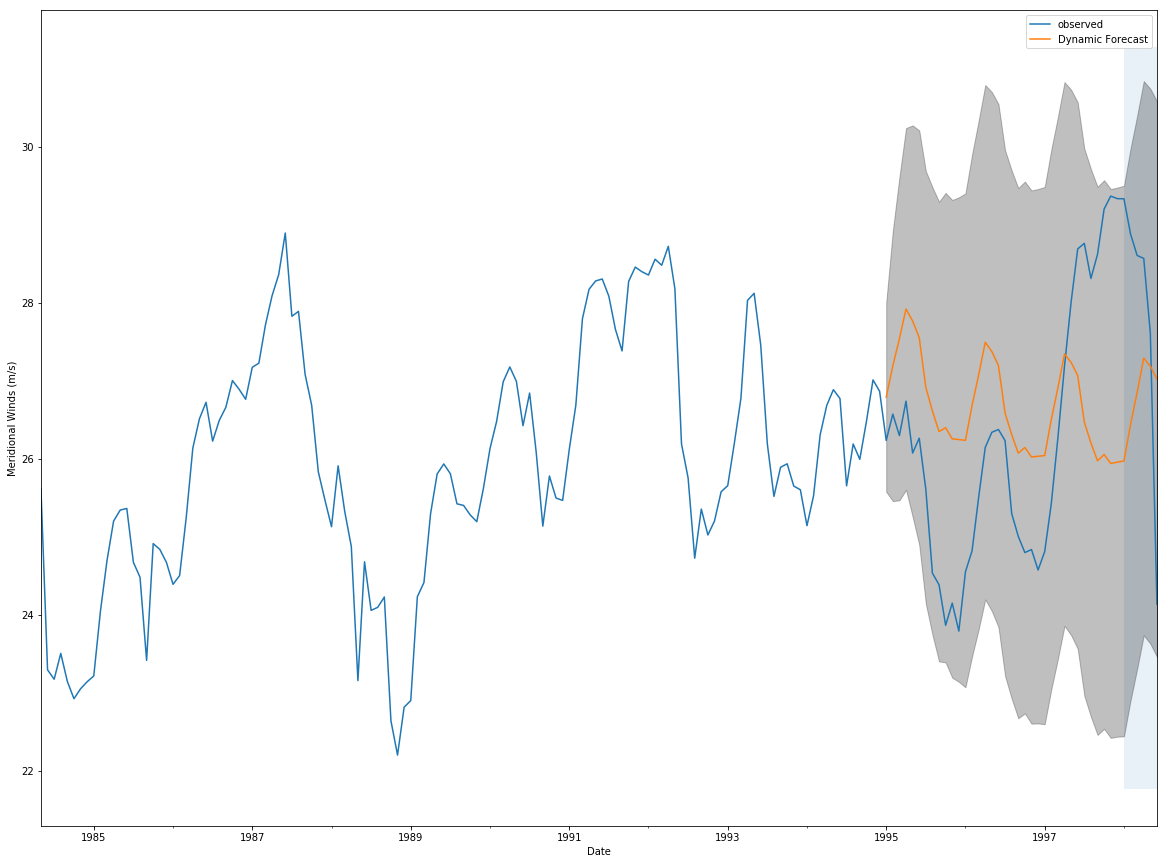

In [177]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1995-01-01'), dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y_rev.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(),
                 pd.to_datetime('1998-01-01'),
                 y_rev.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Meridional Winds (m/s)')

plt.legend()
plt.show()

In [172]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y_rev['1995-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3.37


The MSE is higher than before. This is expected as we are dynamic forecast relies less on historical data. 

### Forecasting the model

#### Finally, we forecast our model predicting 100 months ahead. 

In [174]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

/home/atwenter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



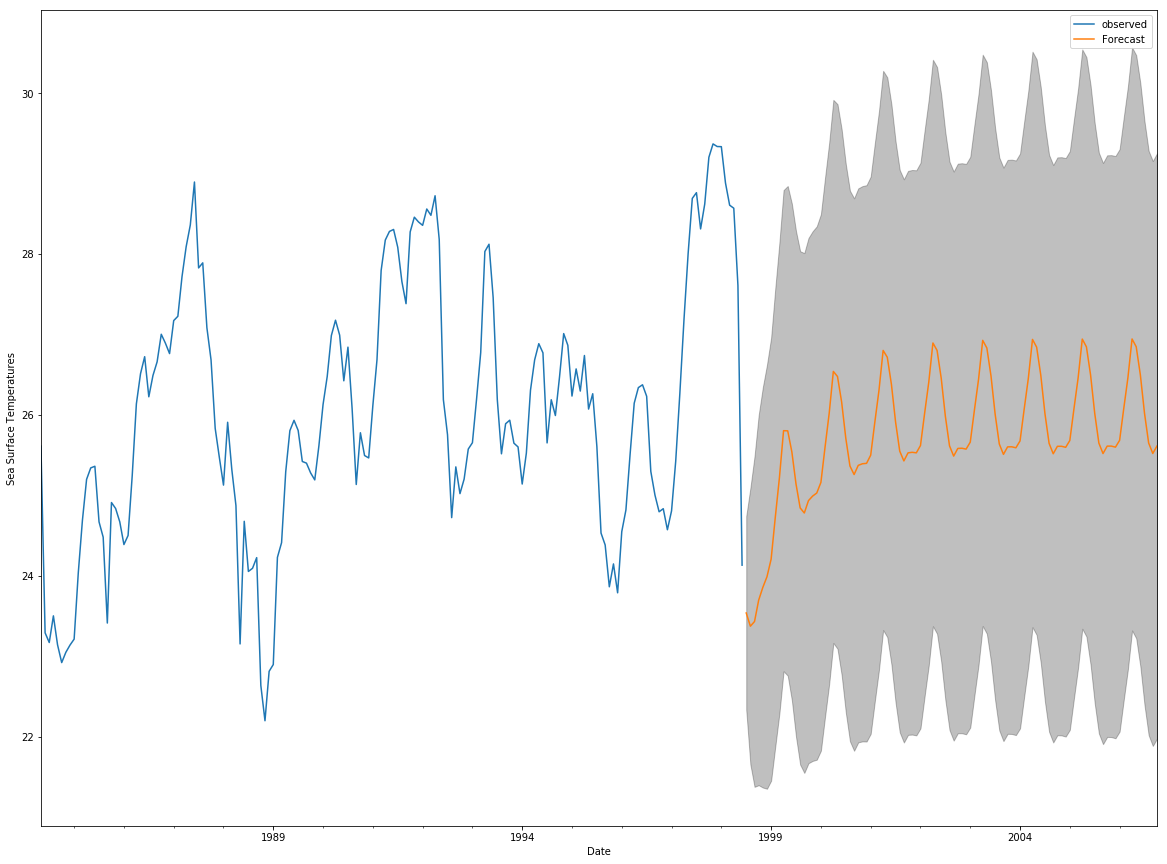

In [175]:
ax = y_rev.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sea Surface Temperatures')

plt.legend()
plt.show()